In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Read the data
df = pd.read_csv('All_Data_Morrisons.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Display basic information
print("Dataset Overview:")
print("\
Shape of dataset:", df.shape)
print("\
First few rows:")
print(df.head())
print("\
Data Info:")
print(df.info())

<ipython-input-10-71415b9331ac>:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('All_Data_Morrisons.csv')


Dataset Overview:
Shape of dataset: (318657, 8)
First few rows:
  supermarket  prices_(£)  prices_unit_(£) unit  \
0   Morrisons        2.10             4.20   kg   
1   Morrisons        2.10             4.20   kg   
2   Morrisons        2.30             2.30    l   
3   Morrisons        3.25             8.13   kg   
4   Morrisons        3.25             8.67   kg   

                                        names       date   category own_brand  
0           Alpro Vanilla Yoghurt Alternative 2024-04-13  free-from     False  
1   Alpro Plain No Sugars Yoghurt Alternative 2024-04-13  free-from     False  
2                  Alpro Barista Coconut Milk 2024-04-13  free-from     False  
3      Morrisons The Best Thick Pork Sausages 2024-04-13  free-from      True  
4  Morrisons The Best Pork Chipolatas 12 Pack 2024-04-13  free-from      True  
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318657 entries, 0 to 318656
Data columns (total 8 columns):
 #   Column           Non-Nu

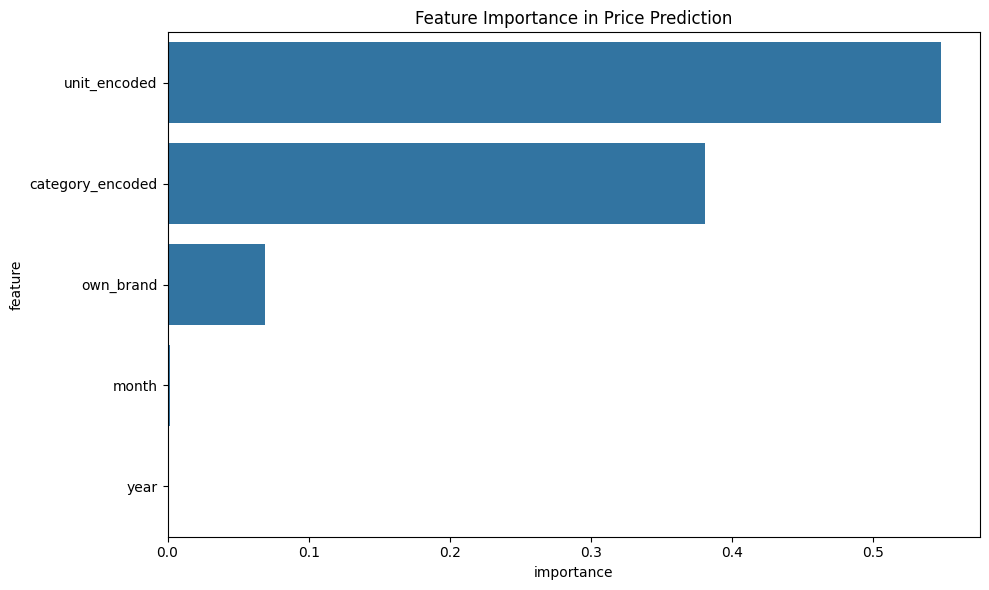

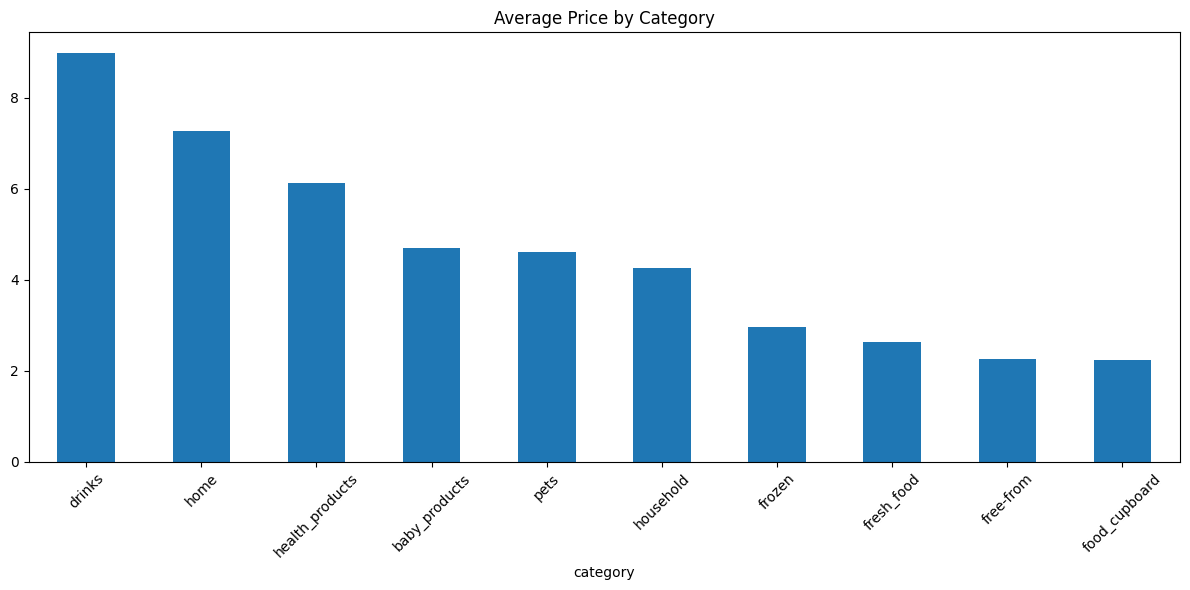

Model Score (R² on test set): 0.24917934208200665
Feature Importance:
            feature  importance
1      unit_encoded    0.548133
0  category_encoded    0.380530
4         own_brand    0.069287
2             month    0.002050
3              year    0.000000


In [ ]:
# Feature Engineering
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])
df['unit_encoded'] = le.fit_transform(df['unit'])

# Create time-based features
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Prepare features for modeling
features = ['category_encoded', 'unit_encoded', 'month', 'year', 'own_brand']
X = df[features]
y = df['prices_(£)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Price Prediction')
plt.tight_layout()
plt.show()

# Price trends by category
plt.figure(figsize=(12, 6))
df.groupby(['category'])['prices_(£)'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Average Price by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\
Model Score (R² on test set):", model.score(X_test, y_test))
print("\
Feature Importance:")
print(feature_importance)

Model Performance Metrics:
Training R² Score: 0.9849278241509608
Testing R² Score: 0.9710775428643457
Testing RMSE: 1.0115081417480263


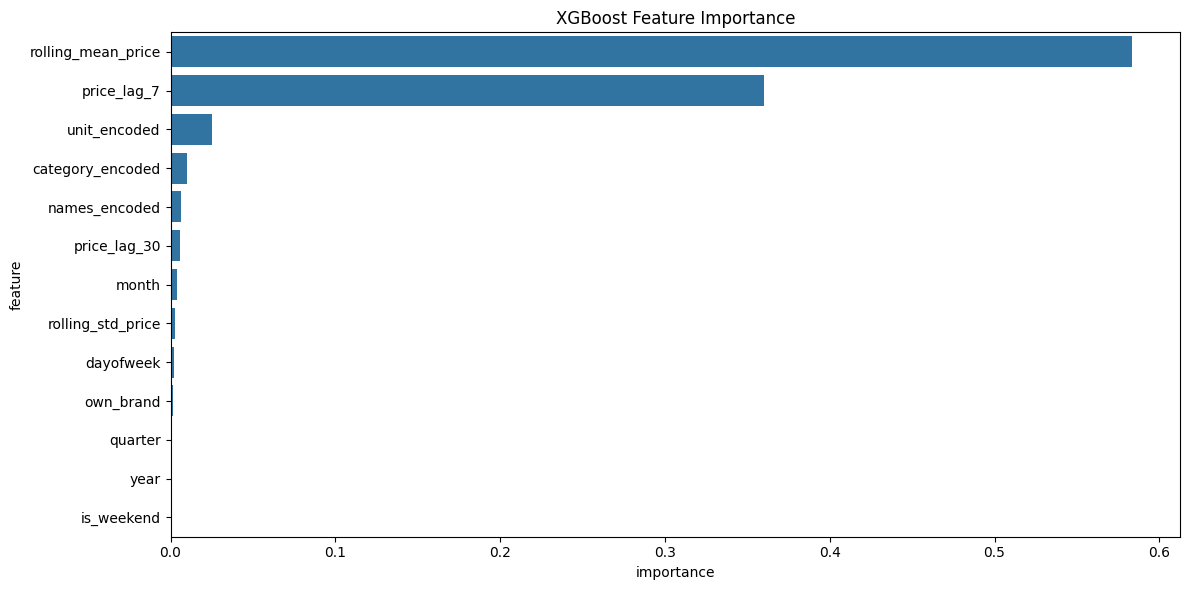

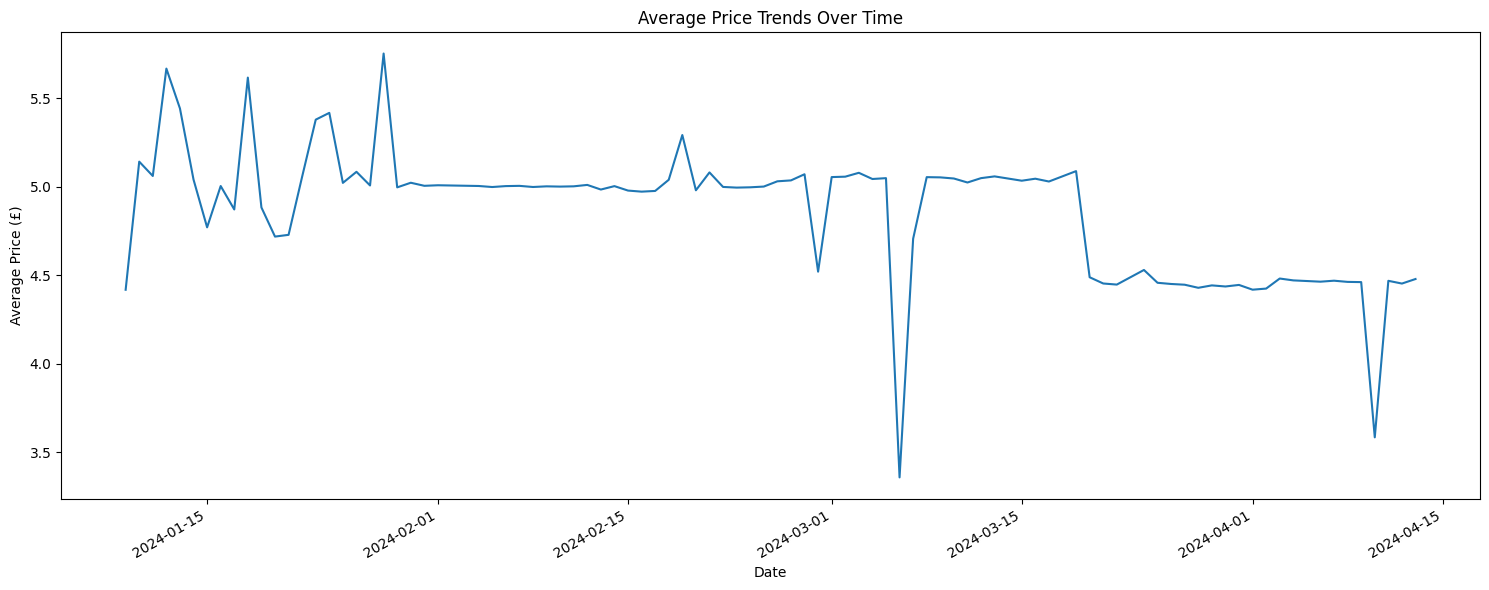

Sample of actual vs predicted prices:
                                        names  prices_(£)  predicted_price
1203064     Palmer's Cocoa Butter Lotion Pump        6.00         5.998251
1203070  Forthglade Natural Soft Bites Salmon        1.80         1.803206
1203039          Belvoir Fruit Ginger Cordial        3.25         3.377000
1203067      Duracell Alkaline MN21 Batterie…        5.00         5.005009
1203076     Morliny Polish Berlinki Z Kurczat        1.80         1.801261


In [ ]:
# Import additional required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Read and preprocess data
df = pd.read_csv('All_Data_Morrisons.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Advanced Feature Engineering
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

# Create price lags and rolling features
df = df.sort_values('date')
df['price_lag_7'] = df.groupby('names')['prices_(£)'].shift(7)
df['price_lag_30'] = df.groupby('names')['prices_(£)'].shift(30)
df['rolling_mean_price'] = df.groupby('names')['prices_(£)'].rolling(window=30).mean().reset_index(0, drop=True)
df['rolling_std_price'] = df.groupby('names')['prices_(£)'].rolling(window=30).std().reset_index(0, drop=True)

# Label encoding for categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_columns = ['category', 'unit', 'names']
for col in categorical_columns:
    df[col + '_encoded'] = le.fit_transform(df[col])

# Prepare features for modeling
feature_columns = ['category_encoded', 'unit_encoded', 'names_encoded',
                  'month', 'quarter', 'year', 'dayofweek', 'is_weekend',
                  'price_lag_7', 'price_lag_30', 'rolling_mean_price',
                  'rolling_std_price', 'own_brand']

# Remove rows with NaN values (created by lag features)
df_clean = df.dropna()

X = df_clean[feature_columns]
y = df_clean['prices_(£)']

# Split data maintaining temporal order
train_size = int(len(df_clean) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Model evaluation
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

print("Model Performance Metrics:")
print("Training R² Score:", r2_score(y_train, train_pred))
print("Testing R² Score:", r2_score(y_test, test_pred))
print("Testing RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Price trends over time
plt.figure(figsize=(15, 6))
df.groupby('date')['prices_(£)'].mean().plot()
plt.title('Average Price Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price (£)')
plt.tight_layout()
plt.show()

# Save model predictions for future use
df_clean['predicted_price'] = xgb_model.predict(X)
print("\
Sample of actual vs predicted prices:")
print(df_clean[['names', 'prices_(£)', 'predicted_price']].head())